In [187]:
import pandas as pd
import numpy as np
import os
import re

In [188]:
def room_division(dataRoom):
    """
    room_division
    -------------
    take all the data and divide the rooms of all PoliTo
    ### Output:
        - the dataframe with the room divided
    """
    Ap = "AP-AULA"
    dataRoom = dataRoom[dataRoom["name_ap"].notnull()]
    dataRoom = dataRoom[dataRoom["name_ap"].str.contains(Ap)]
    rooms = pd.DataFrame()
    rooms[["AP", "Room", "APnum", "NaN"]] = dataRoom["name_ap"].str.split(
        "-", expand=True
    )
    dataRoom = pd.concat([dataRoom, rooms], axis=1)
    dataRoom = dataRoom.drop(["AP", "NaN"], axis=1)
    return dataRoom

In [189]:
dataset_dict = {
    "aula": [],
    "n_devices": [],
    "n_users": [],
    "snr_mean": [],
    "snr_std": [],
    "rssi_mean": [],
    "rssi_std": [],
    "ch_util_2_4_mean": [],
    "ch_util_5_mean": [],
    "noise_2_4_mean": [],
    "noise_5_mean": [],
    "n_people": []
}

path = "ml_data/"
regex_aula = "(AULA.+)_"
regex_n_people = "_([0-9]+)\."


for i, file in enumerate(os.listdir(path)):
    df = pd.read_csv(path + file)
    df.drop(columns=["Unnamed: 0", "Timestamp_y", "ch_2_4", "ch_5", "class", "domain", "client_type", "code_ap"], inplace=True)
    df = room_division(df)

    aula = re.search(regex_aula, file).group(1)
    df_aula = df[df["Room"] == aula]

    if len(df_aula) == 0:
        print(f"{aula} is empty. Skipping the acquisition!")
        continue
    dataset_dict["aula"].append(aula)

    # Feature extrapolation
    df_dist_ap = df_aula.drop_duplicates(subset="APnum")
    n_devices = df_dist_ap["n_clients_2_4"].sum() + df_dist_ap["n_clients_5"].sum()
    dataset_dict["n_devices"].append(n_devices)

    df_dist_users = df_aula.drop_duplicates(subset="user_masked")
    n_users = len(df_dist_users[df_dist_users["snr"] > 20])
    dataset_dict["n_users"].append(n_users)

    snr_mean = df_aula["snr"].mean()
    dataset_dict["snr_mean"].append(snr_mean)
    snr_std = df_aula["snr"].std()
    dataset_dict["snr_std"].append(snr_std)

    rssi_mean = df_aula["rssi"].mean()
    dataset_dict["rssi_mean"].append(rssi_mean)
    rssi_std = df_aula["rssi"].std()
    dataset_dict["rssi_std"].append(rssi_std)

    ch_util_2_4_mean = df_dist_ap["ch_utilization_2_4"].mean()
    dataset_dict["ch_util_2_4_mean"].append(ch_util_2_4_mean)
    ch_util_5_mean = df_dist_ap["ch_utilization_5"].mean()
    dataset_dict["ch_util_5_mean"].append(ch_util_5_mean)

    noise_2_4_mean = df_dist_ap["noise_2_4"].mean()
    dataset_dict["noise_2_4_mean"].append(noise_2_4_mean)
    noise_5_mean = df_dist_ap["noise_5"].mean()
    dataset_dict["noise_5_mean"].append(noise_5_mean)


    x = re.search(regex_n_people, file)
    n_people = int(x.group(1))
    dataset_dict["n_people"].append(n_people)

In [190]:
dataset = pd.DataFrame.from_dict(dataset_dict)
dataset

,aula,n_devices,n_users,snr_mean,snr_std,rssi_mean,rssi_std,ch_util_2_4_mean,ch_util_5_mean,noise_2_4_mean,noise_5_mean,n_people
0,AULA3I,3.0,2,34.000000,5.567764,-57.666667,5.507571,11.666667,15.000000,-90.333333,-90.333333,2
1,AULA7S,123.0,84,42.611570,7.513734,-51.115702,6.344538,38.333333,8.333333,-86.500000,-93.666667,127
2,AULA3P,122.0,87,40.188034,6.497920,-51.393162,5.997064,32.500000,27.500000,-84.500000,-92.250000,111
3,AULAR2,183.0,112,36.335196,7.321620,-53.027933,6.093310,37.750000,5.500000,-81.000000,-90.500000,150
4,AULA3I,6.0,4,34.800000,4.438468,-57.400000,4.449719,15.333333,5.333333,-93.666667,-89.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...
63,AULAR4,90.0,60,38.858824,5.486245,-51.294118,5.254983,50.250000,16.250000,-90.500000,-92.750000,76
64,AULA2P,85.0,59,42.240964,7.032313,-51.156627,7.106304,35.000000,5.250000,-83.000000,-93.500000,80
65,AULA11S,35.0,21,36.875000,8.507113,-54.687500,7.689278,46.000000,14.000000,-86.000000,-90.000000,23
66,AULA9I,29.0,18,31.285714,7.437927,-60.892857,6.511183,14.000000,3.500000,-92.000000,-90.000000,18


<Axes: >

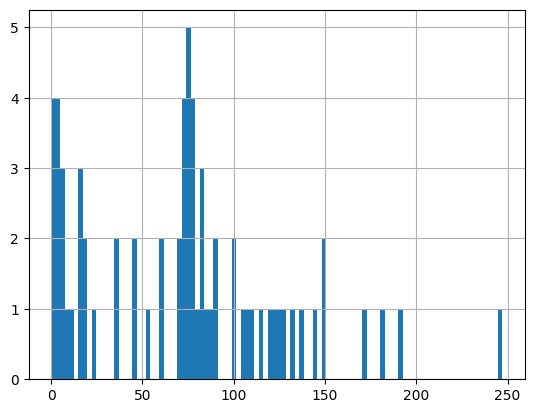

In [193]:
dataset["n_people"].hist(bins=100)

#### Comparison with baseline

In [192]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

print("r2:",r2_score(dataset["n_people"], dataset["n_users"]))
print("MAPE: ",mean_absolute_percentage_error(dataset["n_people"], dataset["n_users"]) )

r2: 0.7415100246733681
MAPE:  132458812569720.86


In [177]:
y = dataset["n_people"].to_numpy()# + (np.random.rand(len(dataset)) * 0.001)
dataset.drop(["aula", "n_people"], axis=1, inplace=True)
X = dataset.to_numpy()# + (np.random.rand(len(dataset), len(dataset.columns)) * 0.001)

### TODO
- Choice of regression model at this [link](https://medium.com/@dnyaneshwalwadkar/regression-a-to-z-choosing-the-correct-type-of-regression-analysis-4cfb29ae5a1)
- Cross validation [here](https://scikit-learn.org/stable/modules/cross_validation.html)

In [178]:
from sklearn.model_selection import train_test_split

#### Static split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)
y_test

Train shape:  (63, 10)
Test shape:  (4, 10)


array([100,  18,  45, 144])

#### Linear regression

In [184]:
from sklearn.linear_model import LinearRegression

In [185]:
lin_reg_model = LinearRegression()
fitted = lin_reg_model.fit(X_train, y_train)

In [186]:
print("R2 train: ", fitted.score(X_train, y_train))
print("R2 test: ", fitted.score(X_test, y_test))
fitted.predict(X_test)

R2 train:  0.850963234660372
R2 test:  0.4495693678889877


array([ 86.15192696,  19.52256297, 108.60889475, 112.35455032])

#### Cross validation

In [171]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [172]:
cv = ShuffleSplit(n_splits=3, test_size=0.1)
scores = cross_val_score(lin_reg_model, X, y, cv=cv)
scores

array([ 0.86168981,  0.19272549, -0.56853424])

In [136]:
mean_absolute_percentage_error(y_test, fitted.predict(X_test))

0.4770581953318645

### Gaussian process regression

In [93]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [94]:
gaus_reg_model = GaussianProcessRegressor()
fitted = gaus_reg_model.fit(X_train, y_train)
fitted.score(X_test, y_test)
fitted.predict(X_train)

array([1.14000816e+02, 1.50000209e+01, 2.00055481e+00, 1.23000620e+02,
       7.60001521e+01, 1.49000716e+02, 6.10001862e+01, 1.19000621e+02,
       8.20005418e+01, 3.50003413e+01, 7.20008822e+01, 1.80005119e+01,
       7.50005808e+01, 8.30008379e+01, 5.40006554e+01, 1.27000426e+02,
       1.00011854e+00, 7.60001584e+01, 4.50003718e+01, 3.00069660e+00,
       6.00070489e+00, 1.92000115e+02, 7.10002977e+01, 3.00087187e+00,
       5.00052180e+00, 1.80009710e+01, 8.00027382e+00, 7.30002472e+01,
       7.30009476e+01, 9.40843851e-04, 2.47000659e+02, 7.20009686e+01,
       7.00064320e+00, 1.10006784e+01, 1.44000530e+02, 2.30002430e+01,
       9.10008646e+01, 7.70004105e+01, 8.70006438e+01, 1.01000540e+02,
       8.50005064e+01, 1.06000951e+02, 7.50000847e+01, 3.50000112e+01,
       8.90009931e+01, 3.00032692e+00, 7.70003715e+01, 1.60006390e+01,
       1.37000016e+02, 1.25000441e+02, 2.00092936e+00, 4.60003342e+01,
       1.11000727e+02, 1.32000625e+02, 8.20005761e+01])

In [95]:
scores = cross_val_score(gaus_reg_model, X, y, cv=cv)
scores

array([-1.35590373, -2.66667525, -4.11816341])

In [96]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_train, fitted.predict(X_train))

9.999999050922895e-11